In [113]:
import pandas as pd
import yfinance as yf
import time
from datetime import datetime, timedelta, date
import math
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from scipy.stats import norm
import plotly.io as pio
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [114]:
from OptionPricingMethods import black_scholes_price, binomial_tree_price, monte_carlo_price

### Real World Analysis

We want to see how these option pricing methods compare with the market prices options have recently been traded at. Using the yfinance library, we can find options that have been recently traded at different strike prices for different stocks (we will focus on the most popular stocks on the market due to limitations in the yfinance data available for less popular stocks).

### Items to Investigate

- Effect of Expiration Date on Option Pricing
- **Effect of Strike Price on Option Pricing**
- Runtime of each Option Pricing Calculation


In [115]:
#Calculates the risk free rate using the 13-week Treasury Yield
irx = yf.Ticker('^IRX')
rf = irx.history(period='1d')['Close'][-1] / 100
rf

0.041579999923706056

In [116]:
def option_price_error_df(ticker, expiration_date_str):
    ''' For the given stock and expiration date, 
        finds the difference between the calculated option prices and the actual option prices,
        returning the corresponding DataFrame
        
        Args:
        - ticker (str): The ticker of the stock
        - expiration_date_str (str): The expiration date of the stock
        
        Return:
        - stock_calls (pd.DataFrame): 
            A DataFrame including the options for the given stock with the given expiration date,
            and different strike prices and pricing errors
    '''
    
    stock = yf.Ticker(ticker)
    #Finds all of the call options for the given expiration date
    stock_calls = stock.option_chain(expiration_date_str).calls
    #Ensures we are only looking at options traded in the past 48 hours (avoids drastic ticker price changes)
    s_bool = stock_calls.loc[:, 'lastTradeDate'] > pd.Timestamp.now(tz='UTC') - pd.Timedelta(hours=72)
    stock_calls = stock_calls.loc[s_bool, :].rename(columns={'lastPrice': 'Market Price'})
    #Removes strike prices below $1 (this will unnecessarily hurt the MC calculation)
    s_bool = stock_calls.loc[:, 'strike'] >= 1
    stock_calls = stock_calls.loc[s_bool, :]
    

    expiration_datetime = datetime.strptime(expiration_date_str, '%Y-%m-%d').date()
    time_until_expiration = (expiration_datetime - date.today()).days / 365
    stock_price = stock.history(period='1d')['Close'].iloc[-1]
    
    #For each strike price in the dataset, finds the option price from the corresponding calculation
    stock_calls['BS Price'] = stock_calls.apply(
        lambda row: black_scholes_price(stock_price, row['strike'], rf, time_until_expiration, row['impliedVolatility']),
        axis=1
    )
    stock_calls['BT Price'] = stock_calls.apply(
        lambda row: binomial_tree_price(stock_price, row['strike'], rf, time_until_expiration, row['impliedVolatility'], 10),
        axis=1
    )
    stock_calls['MC Price'] = stock_calls.apply(
        lambda row: monte_carlo_price(stock_price, row['strike'], rf, time_until_expiration, row['impliedVolatility']),
        axis=1
    )
    
    #Finds the Pricing Error for each strike price
    stock_calls['BS Price Error'] = abs(stock_calls['BS Price'] - stock_calls['Market Price'])
    stock_calls['BT Price Error'] = abs(stock_calls['BT Price'] - stock_calls['Market Price'])
    stock_calls['MC Price Error'] = abs(stock_calls['MC Price'] - stock_calls['Market Price'])
    
    return stock_calls
    

In [117]:
def plot_strike_price_error(stock_ticker):
    ''' Given a stock ticker, plots the mean option pricing error
                              across all strike prices for the BS, BT, and MC calculations
                              
    Args:
    - stock_ticker (str): The ticker of the stock'''
    
    
    option_price_error_df_list = []
    stock = yf.Ticker(stock_ticker)
    stock_expiration_dates = stock.options
    for expiration_date in stock_expiration_dates:
        expiration_date_df = option_price_error_df(stock_ticker, expiration_date)
        option_price_error_df_list.append(expiration_date_df)
    total_option_price_error_df = pd.concat(option_price_error_df_list)
    s_bool = total_option_price_error_df.loc[:, 'strike'] > 10
    total_option_price_error_df = total_option_price_error_df.loc[s_bool, :]
    total_option_price_error_df = total_option_price_error_df.groupby('strike').filter(lambda x: len(x) >= 5).groupby('strike').mean().reset_index()

    
    #Creates a multi-line plot with Strike Price on the x-axis, Mean Price Error on the y-axis
    fig = go.Figure()
    #BS Line
    fig.add_trace(go.Scatter(x=total_option_price_error_df['strike'],
                             y=total_option_price_error_df['BS Price Error'],
                             mode='lines+markers',
#                              mode='markers',
                             name='Mean BS Price Error'))
    #BT Line
    fig.add_trace(go.Scatter(x=total_option_price_error_df['strike'],
                             y=total_option_price_error_df['BT Price Error'],
                             mode='lines+markers',
#                              mode='markers',
                             name='Mean BT Price Error'))
    #MC Line
    fig.add_trace(go.Scatter(x=total_option_price_error_df['strike'],
                             y=total_option_price_error_df['MC Price Error'],
                             mode='lines+markers',
#                              mode='markers',
                             name='Mean MC Price Error'))
    #Adds vertical line to indicate current stock price
    fig.add_trace(go.Scatter(
        x=[stock.history(period='1d')['Close'][-1], stock.history(period='1d')['Close'][-1]],
        y=[-1, max(total_option_price_error_df['BS Price Error'].max(),
                   total_option_price_error_df['BT Price Error'].max(),
                   total_option_price_error_df['MC Price Error'].max())], 
        mode='lines',
        line=dict(color='purple', width=3, dash='dash'),
        name='Current Stock Price'
    ))
    fig.update_layout(yaxis=dict(range=[0, max(total_option_price_error_df['BS Price Error'].max(),
                                               total_option_price_error_df['BT Price Error'].max(),
                                               total_option_price_error_df['MC Price Error'].max())]),
                      title=f'{stock_ticker} - Strike Price vs. Mean Pricing Error',
                      xaxis_title='Strike Price',
                      yaxis_title='Mean Pricing Error (across alll Expiration Dates)',
                      width=800, height=600, legend=dict(font=dict(size= 15)))
    pio.renderers.default = 'svg'
    fig.show()
    
    return total_option_price_error_df
    
    

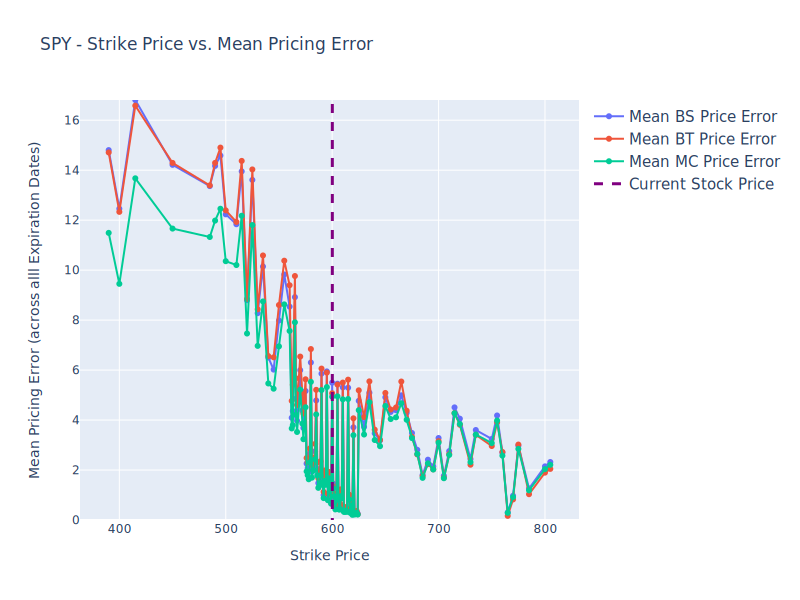

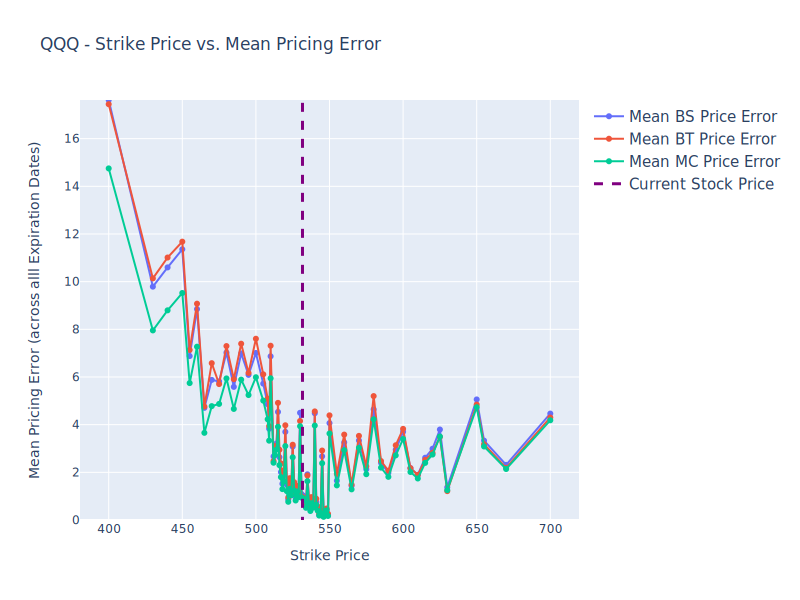

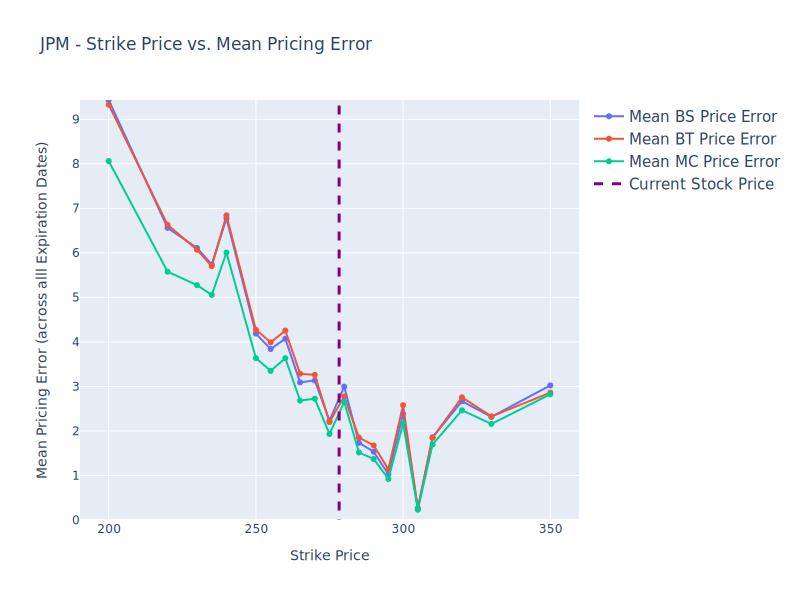

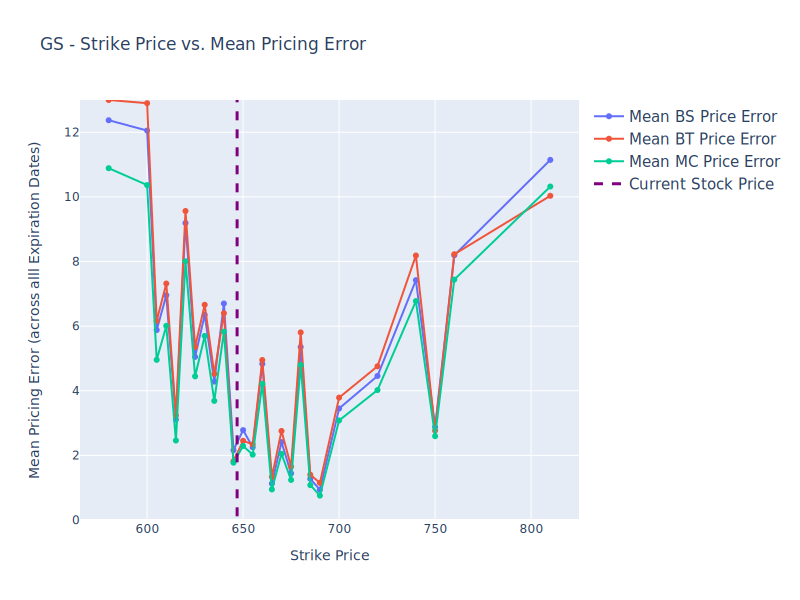

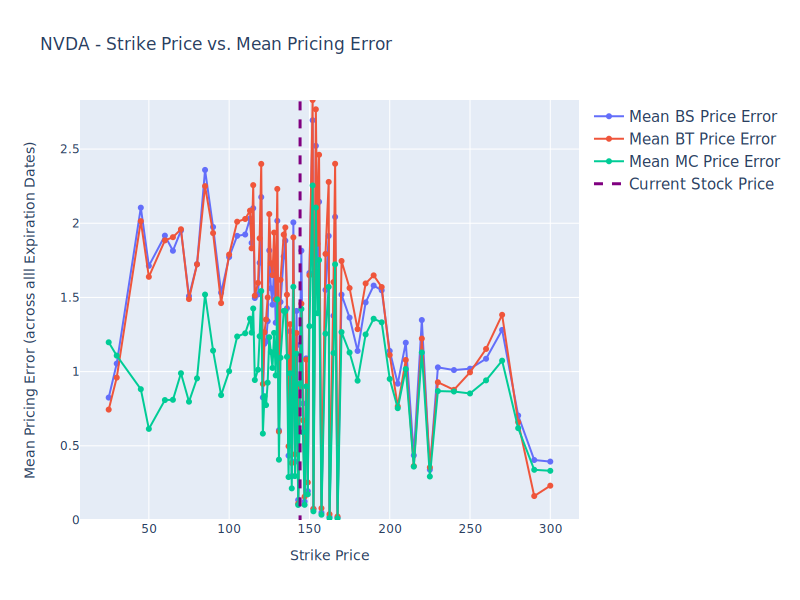

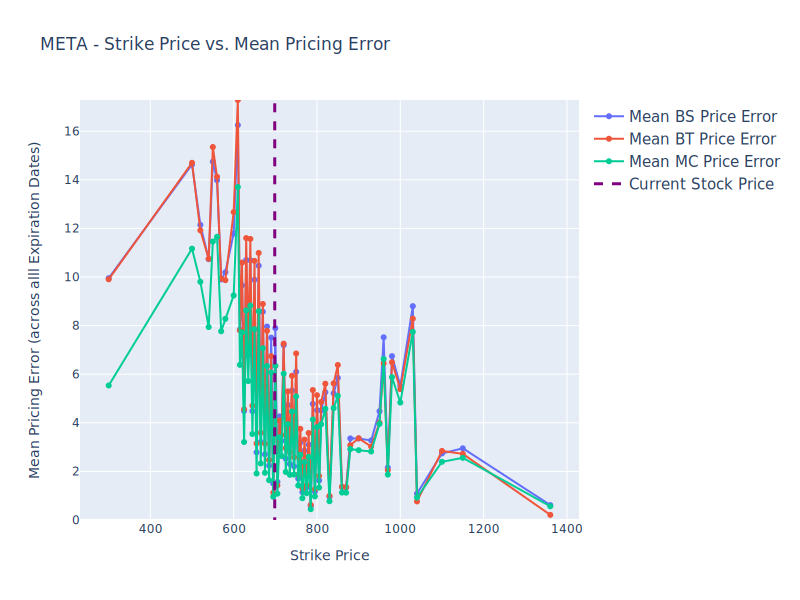

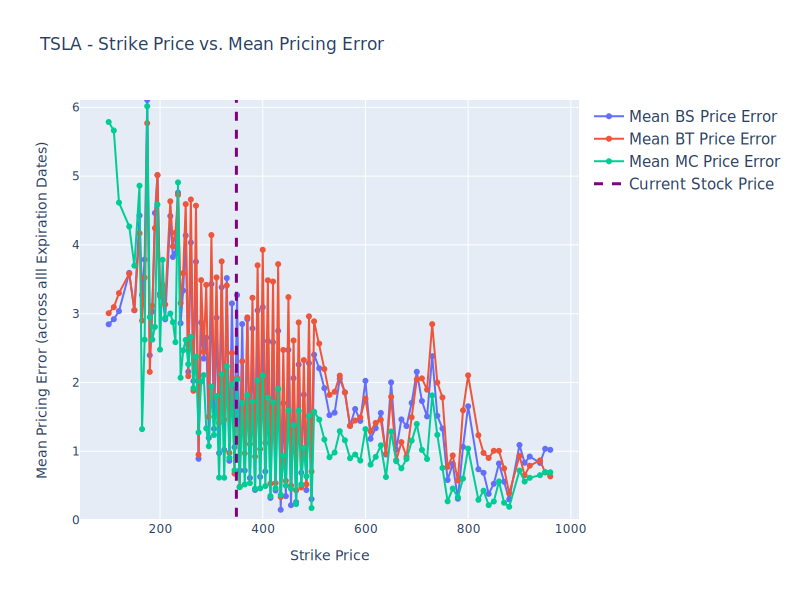

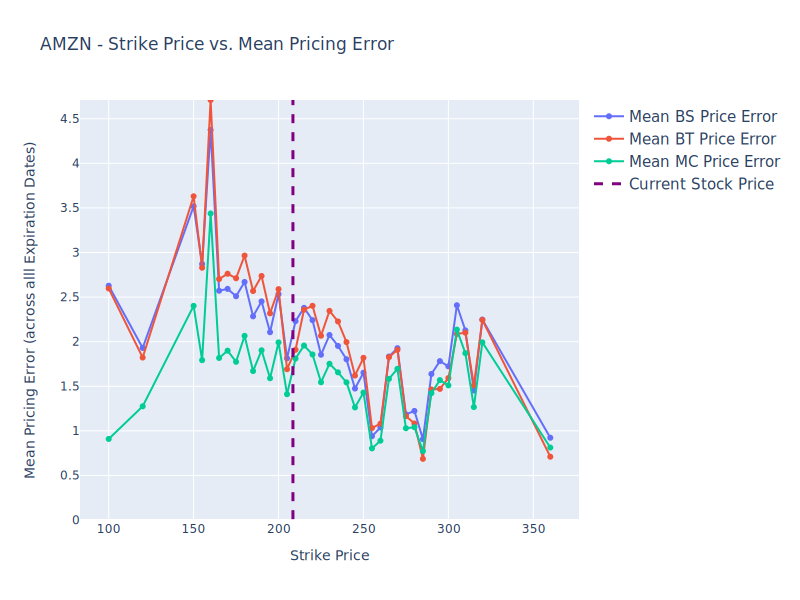

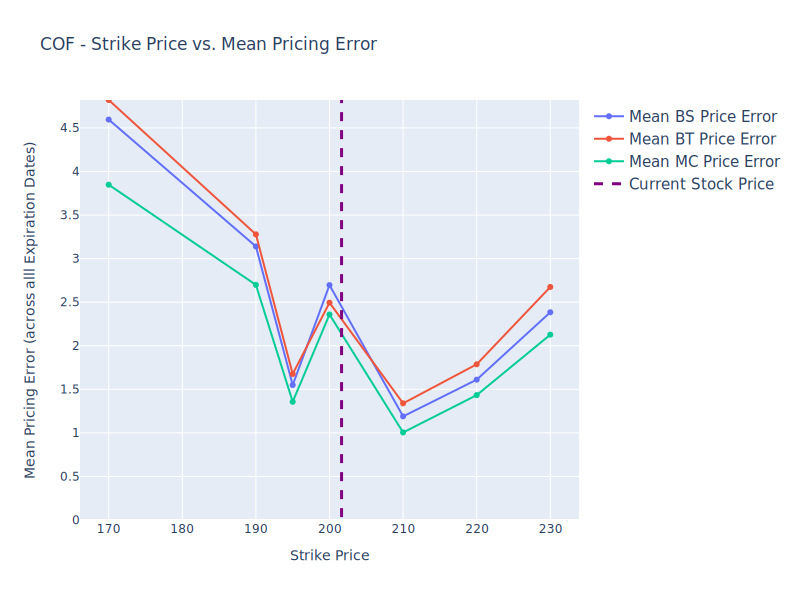

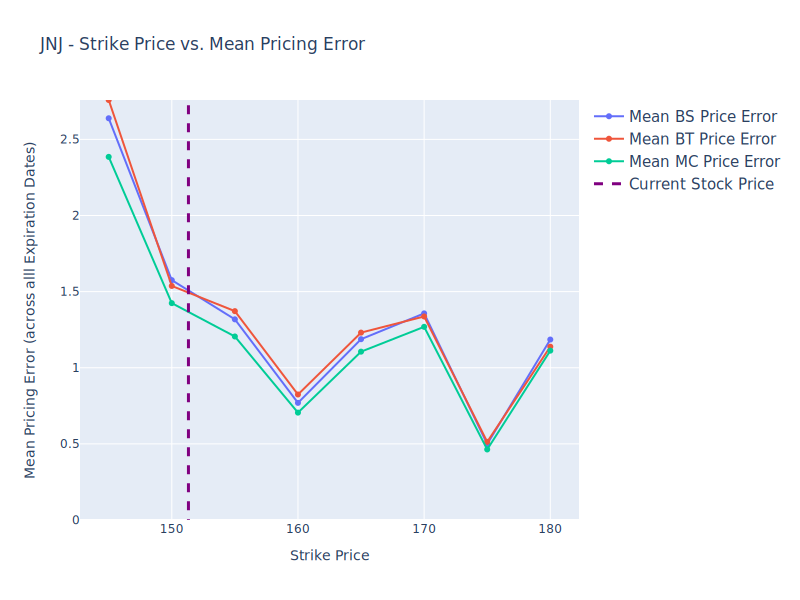

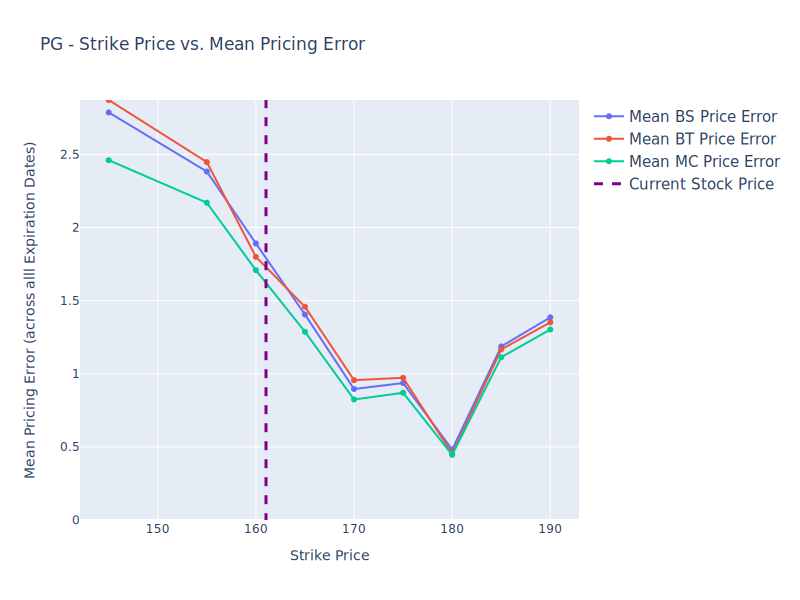

In [118]:
stock_tickers = ['SPY', 'QQQ', 'JPM', 'GS', 'NVDA', 'META', 'TSLA', 'AMZN', 'COF', 'JNJ', 'PG']

for stock_ticker in stock_tickers:
    plot_strike_price_error(stock_ticker)

### Strike Price Analysis

Overall, we can see that all 3 option pricing calculation methods are more accurate for out-of-the-money options rather than in-the-money options. This could be a result of additional changes to the in-the-money option price to avoid any arbitrage opportunities as a result of the intrinsic value (immediate payoff) of the option.

We can also see that across all of the stocks, the 3 option pricing methods have the same trend of errors as the strike price. However, the Monte Carlo method seems to have a slightly better performance across all stocks, though not to the same extent we saw in our expiration date analysis.